# Bayesian Optimization Tutorial: Controller Tuning for Classical Control Task using the Ax package.   
**By Wenjie Xu**

Throughout this tutorial, you will see blocks of code. In some of the places, they contain a block of code like:
```python
## Edit here.
...
## Stop editing here. 
```

These indicate the part of code with different parameters, so that you can experiment with changing parameters. Remember that these hyperparameters may have far-reaching effects on the whole tutorial!  

### Introduction
For this tutorial, we will attempt to tune a PID controller for the classical acrobot.

The two main components of Bayesian optimization are:
1. Defining the reward in this case, which is to be maximized. 
2. An "acqusition function" $q(x)$ that informs us of the value in samping the new point $x$ for optimization purpose.

In [1]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib.animation import FuncAnimation
from IPython.display import Video, display
from render import show_video

# The goal is to swing the free end of the outer-link to reach the target height controlled by a PID controller as quickly as possible.

In [2]:
display(Video('./render_videos/acrobot_play.mp4', embed=True))

In [3]:
# import Ax related packages
from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.utils.notebook.plotting import init_notebook_plotting, render

In [4]:
# construct an Ax client to interact with the ax packages
controller_tuner_client = AxClient()

[INFO 06-16 19:06:26] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.


In [5]:
# create an experiment 
# Create an experiment with required arguments: name, parameters, and objective_name.
controller_tuner_client.create_experiment(
    name="tune_acrobot",  # The name of the experiment.
    parameters=[
        {
            "name": "kp",  # The name of the parameter.
            "type": "range",  # The type of the parameter ("range", "choice" or "fixed").
            "bounds": [-5.0, 5.0],  # The bounds for range parameters. 
            # "values" The possible values for choice parameters .
            # "value" The fixed value for fixed parameters.
            "value_type": "float",  # Optional, the value type ("int", "float", "bool" or "str"). Defaults to inference from type of "bounds".
            "log_scale": False,  # Optional, whether to use a log scale for range parameters. Defaults to False.
            # "is_ordered" Optional, a flag for choice parameters.
        },
        {
            "name": "ki",  
            "type": "range",  
            "bounds": [-5.0, 5.0],  
        },
        {
            "name": "kd", 
            "type": "range",
            "bounds": [-3.0, 3.0]
        }
    ],
    objectives={"reward": ObjectiveProperties(minimize=False)},  # The objective name and minimization setting.
    # parameter_constraints: Optional, a list of strings of form "p1 >= p2" or "p1 + p2 <= some_bound".
    # outcome_constraints: Optional, a list of strings of form "constrained_metric <= some_bound".
)

[INFO 06-16 19:06:26] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter ki. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 06-16 19:06:26] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter kd. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 06-16 19:06:26] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='kp', parameter_type=FLOAT, range=[-5.0, 5.0]), RangeParameter(name='ki', parameter_type=FLOAT, range=[-5.0, 5.0]), RangeParameter(name='kd', parameter_type=FLOAT, range=[-3.0, 3.0])], parameter_constraints=[]).
[INFO 06-16 19:06:26] ax.modelbridge.dispatch_utils: Using Models.GPEI since there are more ordered parameters than there are categories for the unordered categorical paramet

# Define how to evaluate the objective

In [6]:
# Function to compute PID control signal
def compute_pid_control(kp, ki, kd, target, current, prev_error, integral):
    error = target - current
    integral += error
    derivative = error - prev_error
    control_signal = kp * error + ki * integral + kd * derivative
    return control_signal, error, integral
    
# Main function to control the acrobot environment
def control_acrobot(kp, ki, kd, epoch_num=5):
    # Create the acrobot environment
    env = gym.make('Acrobot-v1')
    
    # Control loop
    total_reward_list = []
    for epoch_id in range(epoch_num):
        total_reward = 0
        frames = []
        env.reset()
        # Initialize PID control parameters
        prev_error = 0
        integral = 0    
        for _ in range(500):
            # Get current state
            state = env.state
            # Compute PID control signal for the second joint angle (link1)
            control_signal, prev_error, integral = compute_pid_control(kp, ki, kd, 0, state[0], prev_error, integral)
            # Apply control signal as action
            action = np.array([control_signal])
            # Step the environment
            next_state, reward, done, _ = env.step(max(min(int(control_signal), 2),0))
            # Render the environment
            frames.append(env.render(mode='rgb_array'))
            # env.render()
            # Check if episode is done
            if done:
                break
            total_reward += reward
        total_reward_list.append(total_reward)
    # Close the environment
    env.close()
    
    return np.mean(total_reward_list), frames

In [7]:
# calculate the reward
def pid_to_reward(pid):
    kp = pid['kp']
    ki = pid['ki']
    kd = pid['kd']
    mean_total_reward, frames = control_acrobot(kp, ki, kd)
    return mean_total_reward

# feed in a set of parameters and visualize the running result
def pid_to_frames(pid):
    kp = pid['kp']
    ki = pid['ki']
    kd = pid['kd']
    mean_total_reward, frames = control_acrobot(kp, ki, kd, epoch_num=1)
    return frames

# Running the optimization loop

In [8]:
init_parameters = {
    "kp": 0.1, "ki": 0.1, "kd": 0.1
}

controller_tuner_client.attach_trial(
    parameters=init_parameters
)

# Get the parameters and run the trial 
baseline_parameters = controller_tuner_client.get_trial_parameters(trial_index=0)
controller_tuner_client.complete_trial(trial_index=0, raw_data=pid_to_reward(baseline_parameters))

[INFO 06-16 19:06:26] ax.core.experiment: Attached custom parameterizations [{'kp': 0.1, 'ki': 0.1, 'kd': 0.1}] as trial 0.
[INFO 06-16 19:06:35] ax.service.ax_client: Completed trial 0 with data: {'reward': (-499.0, None)}.


In [9]:
# run the optimization loop
for i in range(25):
    parameters, trial_index = controller_tuner_client.get_next_trial()
    # Local evaluation here can be replaced with deployment to external system.
    controller_tuner_client.complete_trial(trial_index=trial_index, raw_data=pid_to_reward(parameters))

[INFO 06-16 19:06:35] ax.service.ax_client: Generated new trial 1 with parameters {'kp': 0.969478, 'ki': 0.530509, 'kd': 2.011232}.
[INFO 06-16 19:06:43] ax.service.ax_client: Completed trial 1 with data: {'reward': (-499.0, None)}.
[INFO 06-16 19:06:43] ax.service.ax_client: Generated new trial 2 with parameters {'kp': -0.777022, 'ki': -1.616158, 'kd': -2.00573}.
[INFO 06-16 19:06:45] ax.service.ax_client: Completed trial 2 with data: {'reward': (-195.8, None)}.
[INFO 06-16 19:06:45] ax.service.ax_client: Generated new trial 3 with parameters {'kp': -4.172576, 'ki': -0.491147, 'kd': -1.266748}.
[INFO 06-16 19:06:50] ax.service.ax_client: Completed trial 3 with data: {'reward': (-325.2, None)}.
[INFO 06-16 19:06:50] ax.service.ax_client: Generated new trial 4 with parameters {'kp': 2.981477, 'ki': 1.4719, 'kd': -2.813424}.
[INFO 06-16 19:06:56] ax.service.ax_client: Completed trial 4 with data: {'reward': (-499.0, None)}.
[INFO 06-16 19:06:56] ax.service.ax_client: Generated new trial 

In [10]:
best_parameters, _ = controller_tuner_client.get_best_parameters()
print(best_parameters)

{'kp': 5.0, 'ki': -5.0, 'kd': 0.35929947527451134}


# Visualize the improvement 

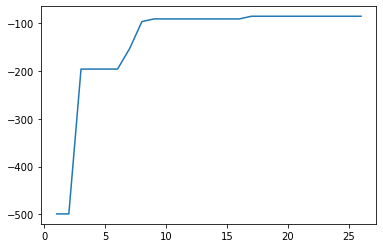

In [11]:
plt.plot(controller_tuner_client.get_optimization_trace()[0]['data'][0]['x'], controller_tuner_client.get_optimization_trace()[0]['data'][0]['y']) 

In [12]:
init_frames = pid_to_frames(init_parameters) 
show_video(init_frames)

Moviepy - Building video ./render_videos/tmp.mp4.
Moviepy - Writing video ./render_videos/tmp.mp4



Moviepy - Done !
Moviepy - video ready ./render_videos/tmp.mp4


In [13]:
best_frames = pid_to_frames(best_parameters)
show_video(best_frames)

Moviepy - Building video ./render_videos/tmp.mp4.
Moviepy - Writing video ./render_videos/tmp.mp4



Moviepy - Done !
Moviepy - video ready ./render_videos/tmp.mp4
